<a href="https://colab.research.google.com/github/faezeh-lbf/Probing-Persian-Language-Models/blob/main/Breakable_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
! pip install git+https://github.com/huggingface/transformers.git
! pip install git+https://github.com/huggingface/datasets.git
from IPython.display import clear_output 
!pip install -q sentencepiece
# !pip install ipywidgets
# !pip install bertviz
clear_output()

In [ ]:
!pip install tqdm --upgrade


## Loading the dataset

In [ ]:
from datasets import load_dataset, list_datasets, load_metric, load_dataset
import numpy as np

BATCH_SIZE = 32
batch_size = BATCH_SIZE
# OPTIONS_ORDER = ['بزرگتر', 'کوچکتر']


# size
# datasets = load_dataset('json', data_files='/content/size_comp_train.jsonl').shuffle()
# dataset_test = load_dataset('json', data_files='/content/size_comp_dev.jsonl').shuffle()
datasets = load_dataset('json', data_files='/content/breakable_train2_nolang.jsonl').shuffle()
dataset_test = load_dataset('json', data_files='/content/breakable_dev1.jsonl').shuffle()

# # num
# datasets = load_dataset('json', data_files='/content/ant-syn_train.jsonl').shuffle()
# dataset_test = load_dataset('json', data_files='/content/ant-syn_dev.jsonl').shuffle()

# age

# datasets = load_dataset('json', data_files='/content/age_comp_train.jsonl').shuffle()
# dataset_test = load_dataset('json', data_files='/content/age_comp_dev.jsonl').shuffle()

datasets = datasets['train'].train_test_split(test_size=0.1)
datasets['validation'] = datasets['test']
datasets['test'] = dataset_test['train']

Using custom data configuration default-063584867fd76e67
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-063584867fd76e67/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/json/default-063584867fd76e67/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264/cache-586b978c69010b25.arrow
Using custom data configuration default-be3ea5e40df5363b
Reusing dataset json (/root/.cache/huggingface/datasets/json/default-be3ea5e40df5363b/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264)
Loading cached shuffled indices for dataset at /root/.cache/huggingface/datasets/json/default-be3ea5e40df5363b/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264/cache-331690e607509901.arrow
Loading cached split indices for dataset at /root/.cache/huggingface/datasets/json/default-063584867fd76e67/0.0.0/45636811569ec4a6630521c18235dfbbab

In [ ]:
# nolang datasets
from datasets import load_dataset, list_datasets, load_metric, load_dataset
import numpy as np

BATCH_SIZE = 32
batch_size = BATCH_SIZE
# OPTIONS_ORDER = ['بزرگتر', 'کوچکتر']


# size
# nolang_datasets = load_dataset('json', data_files='/content/nolang_size_comp_train.jsonl').shuffle()
# nolang_dataset_test = load_dataset('json', data_files='/content/nolang_size_comp_dev.jsonl').shuffle()
nolang_datasets = load_dataset('json', data_files='/content/breakable_train2_nolang.jsonl').shuffle()
nolang_dataset_test = load_dataset('json', data_files='/content/breakable_dev1_nolang.jsonl').shuffle()

# # num
# datasets = load_dataset('json', data_files='/content/ant-syn_train.jsonl').shuffle()
# dataset_test = load_dataset('json', data_files='/content/ant-syn_dev.jsonl').shuffle()

# age
# datasets = load_dataset('json', data_files='/content/age_comp_train.jsonl').shuffle()
# dataset_test = load_dataset('json', data_files='/content/age_comp_dev.jsonl').shuffle()

nolang_datasets = nolang_datasets['train'].train_test_split(test_size=0.1)
nolang_datasets['validation'] = nolang_datasets['test']
nolang_datasets['test'] = nolang_dataset_test['train']

Using custom data configuration default-063584867fd76e67


0 tables [00:00, ? tables/s]

Using custom data configuration default-532445b518491a1a


Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-063584867fd76e67/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264. Subsequent calls will reuse this data.


0 tables [00:00, ? tables/s]

Dataset json downloaded and prepared to /root/.cache/huggingface/datasets/json/default-532445b518491a1a/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264. Subsequent calls will reuse this data.


In [ ]:
nolang_datasets

# Common

In [ ]:
from transformers import AutoModelForMaskedLM, AutoTokenizer


In [ ]:

# @title model checkpoints
# eng_model_checkpoint = "bert-base-uncased"
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
# model_checkpoint = "HooshvareLab/albert-fa-zwnj-base-v2"
# model_checkpoint = 'bert-base-multilingual-cased'
# model_checkpoint = 'HooshvareLab/roberta-fa-zwnj-base'

# roberta-fa-zwnj-base
# TODO: change Model to persian one


In [ ]:
# @title learning curve functions
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup, AdamW


def create_dataloader(dataset, batch_size=BATCH_SIZE):
  dataloader = DataLoader(
            dataset,  # The training samples.
            sampler = RandomSampler( dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )
  return dataloader

def prepare_model(model_class, model_checkpoint):
  tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
  base_model = AutoModelForMaskedLM.from_pretrained(model_checkpoint, return_dict = True)
  
  model = model_class(base_model, tokenizer)
  model.cuda()
  return model

  

def learning_curve(model_class, model_checkpoint, datasets, learning_sizes = [64, 128, 256, 512, 1024, 2048], batch_size=BATCH_SIZE):
  train_dataset = datasets['train']
  val_dataset = datasets['validation']
  val_dataset = prepare_dataset(val_dataset)

  validation_dataloader = create_dataloader(val_dataset, batch_size)
  test_dataloader = create_dataloader(prepare_dataset(datasets['test']), batch_size)

  results = {}

  for c in learning_sizes:
    if len(datasets['train']) > c:
      train_dataset2 = prepare_dataset(train_dataset, c)
      train_dataloader = create_dataloader(train_dataset2, batch_size)
      model = prepare_model(model_class, model_checkpoint)
      train_model(model, train_dataloader, validation_dataloader)
      eval_result = evaluate_model(model, test_dataloader)
      results[c] = eval_result
    else:
      c = len(datasets['train'])
      train_dataset2 = prepare_dataset(train_dataset, c)
      train_dataloader = create_dataloader(train_dataset2, batch_size)
      model = model_class()
      train_model(model, train_dataloader, validation_dataloader)
      eval_result = evaluate_model(model, test_dataloader)
      results[c] = evel_result
      return results
  return results


In [ ]:
# @title fix label

def fix_labels(ex):
  c=ex['question']['choices']
  options = []
  for i in c:
    options.append(i['text'])
  options = [tokenizer.encode(option)[1] for option in options]
  ex['fixed_label']=ex['label']
  # print(options)
  ex['options'] = torch.tensor(options)
  ex['question']['stem']=ex['question']['stem'].replace('[MASK]',tokenizer.mask_token)
  enc=tokenizer.encode_plus(ex['question']['stem'],truncation=True,padding='max_length', max_length=64)
  ex={**ex,**enc}
  sol = {}
  cols = ['input_ids', 'attention_mask', 'fixed_label', 'options']
  for k in ex:
    if k in cols:
      sol[k] = ex[k]
  return sol

def prepare_dataset(dataset, data_size = -1):
  if data_size != -1:
    dataset = dataset.train_test_split(data_size, seed = np.random.randint(1000))['test']
  encoded_dataset = dataset.map(fix_labels)
  # print(encoded_dataset[0])
  # raise 1
  encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'fixed_label', 'options'])
  return encoded_dataset



In [ ]:
# testset = datasets['test']
# testset = prepare_dataset(testset)
# print(testset)

In [ ]:
# @title train_model function

# def train_model(model, train_dataloader, validation_dataloader):

#   # Set the seed value all over the place to make this reproducible.
#   seed_val = 42

#   random.seed(seed_val)
#   np.random.seed(seed_val)
#   torch.manual_seed(seed_val)
#   torch.cuda.manual_seed_all(seed_val)

#   # We'll store a number of quantities such as training and validation loss, 
#   # validation accuracy, and timings.
#   training_stats = []

#   # Measure the total training time for the whole run.
#   total_t0 = time.time()

#   optimizer = AdamW(model.parameters(),
#                     lr = 2e-3, # args.learning_rate - default is 5e-5, our notebook had 2e-5
#                     eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
#                   )
#   total_steps = len(train_dataloader) * epochs
#   scheduler = get_linear_schedule_with_warmup(optimizer, 
#                                               num_warmup_steps = 0, # Default value in run_glue.py
#                                               num_training_steps = total_steps)
#   criterion = torch.nn.CrossEntropyLoss() 

#   # For each epoch...
#   for epoch_i in range(0, epochs):
      
#       # ========================================
#       #               Training
#       # ========================================
      
#       # Perform one full pass over the training set.

#       print("")
#       print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
#       print('Training...')

#       # Measure how long the training epoch takes.
#       t0 = time.time()

#       # Reset the total loss for this epoch.
#       total_train_loss = 0

#       # Put the model into training mode. Don't be mislead--the call to 
#       # `train` just changes the *mode*, it doesn't *perform* the training.
#       # `dropout` and `batchnorm` layers behave differently during training
#       # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
#       model.train()

#       # For each batch of training data...
#       for step, batch in enumerate(train_dataloader):

#           # Progress update every 40 batches.
#           if step % 40 == 0 and not step == 0:
#               # Calculate elapsed time in minutes.
#               elapsed = format_time(time.time() - t0)
              
#               # Report progress.
#               print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

#           # Unpack this training batch from our dataloader. 
#           #
#           # As we unpack the batch, we'll also copy each tensor to the GPU using the 
#           # `to` method.
#           #
#           # `batch` contains three pytorch tensors:
#           #   [0]: input ids 
#           #   [1]: attention masks
#           #   [2]: labels 

#           b_input_ids =batch['input_ids'].to(device)
#           # print(b_input_ids)
#           b_input_mask = batch['attention_mask'].to(device)
#           # # token_type_ids = torch.stack(batch['token_type_ids']).to(device)
#           b_labels = batch['fixed_label'].to(device)

#           # Always clear any previously calculated gradients before performing a
#           # backward pass. PyTorch doesn't do this automatically because 
#           # accumulating the gradients is "convenient while training RNNs". 
#           # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
#           model.zero_grad()        

#           # Perform a forward pass (evaluate the model on this training batch).
#           # In PyTorch, calling `model` will in turn call the model's `forward` 
#           # function and pass down the arguments. The `forward` function is 
#           # documented here: 
#           # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
#           # The results are returned in a results object, documented here:
#           # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
#           # Specifically, we'll get the loss (because we provided labels) and the
#           # "logits"--the model outputs prior to activation.
#           # print(b_input_ids.shape,b_labels.shape,b_input_mask.shape)
#           result = model(ids=b_input_ids, 
#                         mask=b_input_mask, 
#                         labels=b_labels) 
#           loss = criterion(result, b_labels)
#           # print(loss)
#           # loss = result.loss
#           # logits = result.logits
#           # print('-----------------loss------------')
#           # print(loss)

#           # Accumulate the training loss over all of the batches so that we can
#           # calculate the average loss at the end. `loss` is a Tensor containing a
#           # single value; the `.item()` function just returns the Python value 
#           # from the tensor.
#           total_train_loss += loss.item()

#           # Perform a backward pass to calculate the gradients.
#           # loss.requires_grad = True
#           loss.backward()

#           # Clip the norm of the gradients to 1.0.
#           # This is to help prevent the "exploding gradients" problem.
#           torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

#           # Update parameters and take a step using the computed gradient.
#           # The optimizer dictates the "update rule"--how the parameters are
#           # modified based on their gradients, the learning rate, etc.
#           optimizer.step()

#           # Update the learning rate.
#           scheduler.step()

#       # Calculate the average loss over all of the batches.
#       avg_train_loss = total_train_loss / len(train_dataloader)            
      
#       # Measure how long this epoch took.
#       training_time = format_time(time.time() - t0)

#       print("")
#       print("  Average training loss: {0:.2f}".format(avg_train_loss))
#       print("  Training epcoh took: {:}".format(training_time))
          
#       # ========================================
#       #               Validation
#       # ========================================
#       # After the completion of each training epoch, measure our performance on
#       # our validation set.

#       print("")
#       print("Running Validation...")

#       t0 = time.time()

#       # Put the model in evaluation mode--the dropout layers behave differently
#       # during evaluation.
#       model.eval()
      
#       # Tracking variables 
#       total_eval_accuracy = 0
#       total_eval_loss = 0
#       nb_eval_steps = 0

#       # Evaluate data for one epoch
#       for batch in validation_dataloader:
          
#           # Unpack this training batch from our dataloader. 
#           #
#           # As we unpack the batch, we'll also copy each tensor to the GPU using 
#           # the `to` method.
#           #
#           # `batch` contains three pytorch tensors:
#           #   [0]: input ids 
#           #   [1]: attention masks
#           #   [2]: labels 
#           # print(batch)
#           b_input_ids = batch['input_ids'].to(device)
#           b_input_mask = batch['attention_mask'].to(device)
#           b_labels = batch['fixed_label'].to(device)
          
#           # Tell pytorch not to bother with constructing the compute graph during
#           # the forward pass, since this is only needed for backprop (training).
#           with torch.no_grad():        

#               # Forward pass, calculate logit predictions.
#               # token_type_ids is the same as the "segment ids", which 
#               # differentiates sentence 1 and 2 in 2-sentence tasks.
#               result = model(ids=b_input_ids, 
#                         mask=b_input_mask, 
#                         labels=b_labels)

#           # Get the loss and "logits" output by the model. The "logits" are the 
#           # output values prior to applying an activation function like the 
#           # softmax.
#           loss = criterion(result, b_labels)
              
#           # Accumulate the validation loss.
#           total_eval_loss += loss.item()

#           # Move logits and labels to CPU
#           logits = result.detach().cpu().numpy()
#           label_ids = b_labels.cpu().numpy()

#           # Calculate the accuracy for this batch of test sentences, and
#           # accumulate it over all batches.
#           total_eval_accuracy += flat_accuracy(logits, label_ids)
          

#       # Report the final accuracy for this validation run.
#       avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
#       print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

#       # Calculate the average loss over all of the batches.
#       avg_val_loss = total_eval_loss / len(validation_dataloader)
      
#       # Measure how long the validation run took.
#       validation_time = format_time(time.time() - t0)
      
#       print("  Validation Loss: {0:.2f}".format(avg_val_loss))
#       print("  Validation took: {:}".format(validation_time))

#       # Record all statistics from this epoch.
#       training_stats.append(
#           {
#               'epoch': epoch_i + 1,
#               'Training Loss': avg_train_loss,
#               'Valid. Loss': avg_val_loss,
#               'Valid. Accur.': avg_val_accuracy,
#               'Training Time': training_time,
#               'Validation Time': validation_time
#           }
#       )

#   print("")
#   print("Training complete!")

#   print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

#   return avg_val_accuracy

In [ ]:
#  @title evaluate_model function

# def evaluate_model(model, test_dataloader):
#   model.eval()

#   # Tracking variables 
#   total_eval_accuracy = 0
#   total_eval_loss = 0
#   # Evaluate data for one epoch
#   for batch in test_dataloader:

#       b_input_ids = batch['input_ids'].to(device)
#       b_input_mask = batch['attention_mask'].to(device)
#       b_labels = batch['fixed_label'].to(device)
#       with torch.no_grad():
#         result = model(ids=b_input_ids, 
#                       mask=b_input_mask, 
#                       labels=b_labels)

#       # Move logits and labels to CPU
#       logits = result.detach().cpu().numpy()
#       label_ids = b_labels.cpu().numpy()

#       # Calculate the accuracy for this batch of test sentences, and
#       # accumulate it over all batches.
#       total_eval_accuracy += flat_accuracy(logits, label_ids)
      

#   # Report the final accuracy for this validation run.
#   avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
#   print("  Accuracy on test set: {0:.2f}".format(avg_val_accuracy))
#   return avg_val_accuracy



In [ ]:
# @title train_model function - real

def train_model(model, train_dataloader, validation_dataloader):
  print("=======================================================================")
  seed_val = 42

  random.seed(seed_val)
  np.random.seed(seed_val)
  torch.manual_seed(seed_val)
  torch.cuda.manual_seed_all(seed_val)

  # We'll store a number of quantities such as training and validation loss, 
  # validation accuracy, and timings.
  training_stats = []

  # Measure the total training time for the whole run.
  total_t0 = time.time()

  optimizer = AdamW(model.parameters(),
                    lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                    eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                  )
  total_steps = len(train_dataloader) * epochs
  scheduler = get_linear_schedule_with_warmup(optimizer, 
                                              num_warmup_steps = 0, # Default value in run_glue.py
                                              num_training_steps = total_steps)
  criterion = torch.nn.CrossEntropyLoss() 

  # For each epoch...
  for epoch_i in range(0, epochs):
      
      # ========================================
      #               Training
      # ========================================
      
      # Perform one full pass over the training set.

      print("")
      print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
      print('Training...')

      # Measure how long the training epoch takes.
      t0 = time.time()

      # Reset the total loss for this epoch.
      total_train_loss = 0

      # Put the model into training mode. Don't be mislead--the call to 
      # `train` just changes the *mode*, it doesn't *perform* the training.
      # `dropout` and `batchnorm` layers behave differently during training
      # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
      model.train()

      # For each batch of training data...
      for step, batch in enumerate(train_dataloader):

          # Progress update every 40 batches.
          if step % 40 == 0 and not step == 0:
              # Calculate elapsed time in minutes.
              elapsed = format_time(time.time() - t0)
              
              # Report progress.
              print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using the 
          # `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 

          b_input_ids =batch['input_ids'].to(device)
          # print(b_input_ids)
          b_input_mask = batch['attention_mask'].to(device)
          # # token_type_ids = torch.stack(batch['token_type_ids']).to(device)
          b_labels = batch['fixed_label'].to(device)
          b_options = batch['options'].to(device)

          # Always clear any previously calculated gradients before performing a
          # backward pass. PyTorch doesn't do this automatically because 
          # accumulating the gradients is "convenient while training RNNs". 
          # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
          model.zero_grad()        

          # Perform a forward pass (evaluate the model on this training batch).
          # In PyTorch, calling `model` will in turn call the model's `forward` 
          # function and pass down the arguments. The `forward` function is 
          # documented here: 
          # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
          # The results are returned in a results object, documented here:
          # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
          # Specifically, we'll get the loss (because we provided labels) and the
          # "logits"--the model outputs prior to activation.
          # print(b_input_ids.shape,b_labels.shape,b_input_mask.shape)
          result = model(ids=b_input_ids, 
                        mask=b_input_mask, 
                        labels=b_labels,
                        options = b_options) 
          
          loss = criterion(result, b_labels)
          # print(loss)
          # loss = result.loss
          # logits = result.logits
          # print('-----------------loss------------')
          # print(loss)

          # Accumulate the training loss over all of the batches so that we can
          # calculate the average loss at the end. `loss` is a Tensor containing a
          # single value; the `.item()` function just returns the Python value 
          # from the tensor.
          # print(loss.item())
          total_train_loss += loss.item()


          # Perform a backward pass to calculate the gradients.
          # print(loss.requires_grad)
          # loss.requires_grad = True
          # loss = Variable(loss, requires_grad = True)
          loss.backward()

          # Clip the norm of the gradients to 1.0.
          # This is to help prevent the "exploding gradients" problem.
          torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

          # Update parameters and take a step using the computed gradient.
          # The optimizer dictates the "update rule"--how the parameters are
          # modified based on their gradients, the learning rate, etc.
          # raise 1

          optimizer.step()

          # Update the learning rate.
          scheduler.step()

      # Calculate the average loss over all of the batches.
      avg_train_loss = total_train_loss / len(train_dataloader)            
      
      # Measure how long this epoch took.
      training_time = format_time(time.time() - t0)
      # for p in params[0:5]:
      #     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
      # par = list(model.named_parameters())
      # params.append(par)
      # print(params[-4])
      print("")
      print("  Average training loss: {0:.2f}".format(avg_train_loss))
      print("  Training epcoh took: {:}".format(training_time))
          
      # ========================================
      #               Validation
      # ========================================
      # After the completion of each training epoch, measure our performance on
      # our validation set.

      print("")
      print("Running Validation...")

      t0 = time.time()

      # Put the model in evaluation mode--the dropout layers behave differently
      # during evaluation.
      model.eval()
      
      # Tracking variables 
      total_eval_accuracy = 0
      total_eval_loss = 0
      nb_eval_steps = 0

      # Evaluate data for one epoch
      for batch in validation_dataloader:
          
          # Unpack this training batch from our dataloader. 
          #
          # As we unpack the batch, we'll also copy each tensor to the GPU using 
          # the `to` method.
          #
          # `batch` contains three pytorch tensors:
          #   [0]: input ids 
          #   [1]: attention masks
          #   [2]: labels 
          # print(batch)
          b_input_ids = batch['input_ids'].to(device)
          b_input_mask = batch['attention_mask'].to(device)
          b_labels = batch['fixed_label'].to(device)
          b_options = batch['options'].to(device)
          
          # Tell pytorch not to bother with constructing the compute graph during
          # the forward pass, since this is only needed for backprop (training).
          with torch.no_grad():        

              # Forward pass, calculate logit predictions.
              # token_type_ids is the same as the "segment ids", which 
              # differentiates sentence 1 and 2 in 2-sentence tasks.
              result = model(ids=b_input_ids, 
                        mask=b_input_mask, 
                        labels=b_labels,
                        options = b_options)

          # Get the loss and "logits" output by the model. The "logits" are the 
          # output values prior to applying an activation function like the 
          # softmax.
          loss = criterion(result, b_labels)
              
          # Accumulate the validation loss.
          total_eval_loss += loss.item()

          # Move logits and labels to CPU
          logits = result.detach().cpu().numpy()
          label_ids = b_labels.cpu().numpy()

          # Calculate the accuracy for this batch of test sentences, and
          # accumulate it over all batches.
          total_eval_accuracy += flat_accuracy(logits, label_ids)
          

      # Report the final accuracy for this validation run.
      avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
      print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

      # Calculate the average loss over all of the batches.
      avg_val_loss = total_eval_loss / len(validation_dataloader)
      
      # Measure how long the validation run took.
      validation_time = format_time(time.time() - t0)
      
      print("  Validation Loss: {0:.2f}".format(avg_val_loss))
      print("  Validation took: {:}".format(validation_time))

      # Record all statistics from this epoch.
      training_stats.append(
          {
              'epoch': epoch_i + 1,
              'Training Loss': avg_train_loss,
              'Valid. Loss': avg_val_loss,
              'Valid. Accur.': avg_val_accuracy,
              'Training Time': training_time,
              'Validation Time': validation_time
          }
      )

  print("")
  print("Training complete!")

  print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))

  return avg_val_accuracy

In [ ]:
#  @title evaluate_model function

def evaluate_model(model, test_dataloader):
  model.eval()

  # Tracking variables 
  total_eval_accuracy = 0
  total_eval_loss = 0
  # Evaluate data for one epoch
  for batch in test_dataloader:

      b_input_ids = batch['input_ids'].to(device)
      b_input_mask = batch['attention_mask'].to(device)
      b_labels = batch['fixed_label'].to(device)
      b_options= batch['options'].to(device)
      with torch.no_grad():
        result = model(ids=b_input_ids, 
                      mask=b_input_mask, 
                      labels=b_labels,
                      options=b_options)

      # Move logits and labels to CPU
      logits = result.detach().cpu().numpy()
      label_ids = b_labels.cpu().numpy()

      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(logits, label_ids)
      

  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
  print("  Accuracy on test set: {0:.2f}".format(avg_val_accuracy))
  return avg_val_accuracy



In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


## curve

In [ ]:
import torch
epochs=3
device = torch.device("cuda")
# model_checkpoint = 'HooshvareLab/roberta-fa-zwnj-base'
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/434 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.22M [00:00<?, ?B/s]

In [ ]:
curve_info = learning_curve(BertBreak_MC_MLM, model_checkpoint, datasets)

In [ ]:
nolang_curve_info = learning_curve(BertBreak_MC_MLM, model_checkpoint, nolang_datasets)

In [ ]:
nolang_curve_info

In [ ]:
curve_info

{64: 0.2673611111111111,
 128: 0.3784722222222222,
 256: 0.5520833333333334,
 512: 0.84375,
 1024: 1.0,
 2048: 1.0}

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

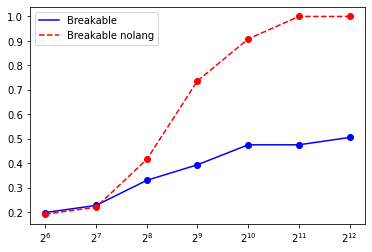

In [ ]:
import matplotlib.pyplot as plt
# roberta - break
curve_info = {64: 0.23133680555555555,
 128: 0.2387152777777778,
 256: 0.28515625,
 512: 0.38237847222222227,
 1024: 0.4735243055555556,
 2048: 0.4735243055555556,
 4096: 0.4735243055555556}
nolang_curve_info = {64: 0.2191840277777778,
 128: 0.2673611111111111,
 256: 0.39409722222222227,
 512: 0.48046875,
 1024: 0.5264756944444444,
 2048: 0.5264756944444444,
 4096: 0.5264756944444444}
##########################################
#  bert - break:
nolang_curve_info = {64: 0.1918402777777778,
 128: 0.22005208333333334,
 256: 0.4153645833333333,
 512: 0.7365451388888888,
 1024: 0.9079861111111112,
 2048: 1.0,
 4096: 1.0}
curve_info = {64: 0.19835069444444445,
 128: 0.22743055555555555,
 256: 0.3298611111111111,
 512: 0.3936631944444444,
 1024: 0.4752604166666667,
 2048: 0.4752604166666667,
 4096: 0.5052604166666667}
plt.plot(list(curve_info.keys()), list(curve_info.values()), 'bo')
plt.plot(list(curve_info.keys()), list(curve_info.values()), 'b-',label = 'Breakable')

plt.plot(list(nolang_curve_info.keys()), list(nolang_curve_info.values()), 'ro')
plt.plot(list(nolang_curve_info.keys()), list(nolang_curve_info.values()), 'r--',label = 'Breakable nolang')

plt.xscale('log', basex=2)
plt.legend()
from google.colab import files
plt.savefig("abc.png")
files.download("abc.png") 

# Breakable task

In [ ]:
from transformers import BertTokenizer, BertForMaskedLM, AutoModelForMaskedLM, AutoTokenizer
from torch.nn import functional
import torch
# model_checkpoint = 'HooshvareLab/roberta-fa-zwnj-base'
# model_checkpoint = "HooshvareLab/albert-fa-zwnj-base-v2"
# model_checkpoint = 'bert-base-multilingual-cased'
model_checkpoint = "HooshvareLab/bert-base-parsbert-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bertmodel = AutoModelForMaskedLM.from_pretrained(model_checkpoint, return_dict = True)

bertmodel.cuda()

Downloading:   0%|          | 0.00/654M [00:00<?, ?B/s]

Some weights of the model checkpoint at HooshvareLab/bert-base-parsbert-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


BertForMaskedLM(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(100000, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=T

In [ ]:
# for p in bertmodel.bert.parameters():
#   p.requires_grad=False


In [ ]:
# # @title fix label
# def fix_labels(ex):
#   c=ex['question']['choices']
#   # for i in c:
#   #   if i['label']==0:
#   #     if i['text']=='کوچکتر':
#   #       ex['fixed_label']=ex['label']
#   #     else:
#   #       ex['fixed_label']=1-ex['label']
#   ex['fixed_label']=ex['label']
  
#   ex['question']['stem']=ex['question']['stem'].replace('[MASK]', tokenizer.mask_token + ' ' + tokenizer.mask_token)
#   enc=tokenizer.encode_plus(ex['question']['stem'],truncation=True,padding='max_length', max_length=64)
  
#   ex={**ex,**enc}
#   return ex

# encoded_dataset = datasets.map(fix_labels)
# encoded_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'fixed_label'])


In [ ]:
# @title dataset loader
from torch.utils.data import TensorDataset, random_split

from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
# dataset = TensorDataset(input_ids, attention_masks, labels)

encoded_dataset = prepare_dataset(datasets)
# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            encoded_dataset['train'],  # The training samples.
            sampler = RandomSampler( encoded_dataset['train']), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            encoded_dataset['validation'], # The validation samples.
            sampler = RandomSampler(encoded_dataset['validation']), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

test_dataloader = DataLoader(
            encoded_dataset['test'], # The validation samples.
            sampler = SequentialSampler(encoded_dataset['test']), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-063584867fd76e67/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264/cache-c1dbf9c776b3f6c3.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-be3ea5e40df5363b/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264/cache-67c34b675139acee.arrow
Loading cached processed dataset at /root/.cache/huggingface/datasets/json/default-063584867fd76e67/0.0.0/45636811569ec4a6630521c18235dfbbab83b7ab572e3393c5ba68ccabe98264/cache-221c0bd750049485.arrow


In [ ]:
# for i , j in enumerate(test_dataloader):
#   print(i,j)
#   break

In [ ]:

# @title Roberta Break_MC_MLM
import torch
from torch.nn import functional


class RobertaBreak_MC_MLM(torch.nn.Module):
  def __init__(self, model, tokenizer):
    # print("__________-----------------------______________")
    super(RobertaBreak_MC_MLM, self).__init__()
    for p in model.roberta.parameters():
      p.requires_grad=False
    self.model = model
    self.model.cuda()
    self.tokenizer = tokenizer
    # self.options = [self.tokenizer.encode(option)[1:3] for option in options]
    # print (self.options)
  
  def forward(self, ids, mask, labels, options):

    output = self.model(ids,attention_mask = mask)
    # options = [self.tokenizer.encode(option)[1] for option in options]
    logits = output.logits

    mask_index = torch.where(ids == tokenizer.mask_token_id)[1]

    # softmax = functional.softmax(logits, dim = -1)
    # print(softmax.shape)
    mask1_word = []
    # mask2_word = []
    for i in range(0, len(mask_index)):
      mask1_word.append(logits[i][mask_index[i]])
    mask1_word =  torch.stack(mask1_word)

    indices1 = torch.tensor(options).to(device)

    predicted1 = []
    for i in range(len(mask1_word)):
      # print("mask, " , mask1_word[i])
      x = [mask1_word[i][j] for j in indices1[i]]
      x = torch.stack(x)
      # print(x.shape)
      predicted1.append(x)

    predicted1 = torch.stack(predicted1)

    predicted = functional.softmax(predicted1)

    return predicted


In [ ]:

# @title Bert Break_MC_MLM
import torch
from torch.nn import functional


class BertBreak_MC_MLM(torch.nn.Module):
  def __init__(self, model, tokenizer):
    # print("__________-----------------------______________")
    super(BertBreak_MC_MLM, self).__init__()
    for p in model.bert.parameters():
      p.requires_grad=False
    self.model = model
    self.model.cuda()
    self.tokenizer = tokenizer
    # self.options = [self.tokenizer.encode(option)[1:3] for option in options]
    # print (self.options)
  
  def forward(self, ids, mask, labels, options):

    output = self.model(ids,attention_mask = mask)
    # options = [self.tokenizer.encode(option)[1] for option in options]
    logits = output.logits

    mask_index = torch.where(ids == tokenizer.mask_token_id)[1]

    # softmax = functional.softmax(logits, dim = -1)
    # print(softmax.shape)
    mask1_word = []
    # mask2_word = []
    for i in range(0, len(mask_index)):
      mask1_word.append(logits[i][mask_index[i]])
    mask1_word =  torch.stack(mask1_word)

    indices1 = torch.tensor(options).to(device)

    predicted1 = []
    for i in range(len(mask1_word)):
      # print("mask, " , mask1_word[i])
      x = [mask1_word[i][j] for j in indices1[i]]
      x = torch.stack(x)
      # print(x.shape)
      predicted1.append(x)

    predicted1 = torch.stack(predicted1)

    predicted = functional.softmax(predicted1)

    return predicted


In [ ]:
for p in model.model.lm_head.parameters():
    print(p.requires_grad)

NameError: ignored

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
bertmodel = AutoModelForMaskedLM.from_pretrained(model_checkpoint, return_dict = True)
bertmodel.cuda()

model = BertBreak_MC_MLM(bertmodel,tokenizer)
model.cuda()
clear_output()

In [ ]:
params = list(model.named_parameters())
# for p in params[0:5]:
#     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
for p in params:
  print(p[-1].grad)
  break
# params[-1][1].grad


### learning loop

In [ ]:
import random, time
import numpy as np
from transformers import get_linear_schedule_with_warmup, AdamW
# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)
criterion = torch.nn.CrossEntropyLoss() 

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()
    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 

        b_input_ids =batch['input_ids'].to(device)
        # print(b_input_ids)
        b_input_mask = batch['attention_mask'].to(device)
        # # token_type_ids = torch.stack(batch['token_type_ids']).to(device)
        b_labels = batch['fixed_label'].to(device)
        b_options = batch['options'].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward` 
        # function and pass down the arguments. The `forward` function is 
        # documented here: 
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        # print(b_input_ids.shape,b_labels.shape,b_input_mask.shape)
        result = model(ids=b_input_ids, 
                       mask=b_input_mask, 
                       labels=b_labels,
                       options = b_options) 
        
        loss = criterion(result, b_labels)
        # print(loss)
        # loss = result.loss
        # logits = result.logits
        # print('-----------------loss------------')
        # print(loss)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        # print(loss.item())
        total_train_loss += loss.item()


        # Perform a backward pass to calculate the gradients.
        # print(loss.requires_grad)
        # loss.requires_grad = True
        # loss = Variable(loss, requires_grad = True)
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        # raise 1

        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)
    # for p in params[0:5]:
    #     print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))
    # par = list(model.named_parameters())
    # params.append(par)
    # print(params[-4])
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()
    
    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        # print(batch)
        b_input_ids = batch['input_ids'].to(device)
        b_input_mask = batch['attention_mask'].to(device)
        b_labels = batch['fixed_label'].to(device)
        b_options = batch['options'].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(ids=b_input_ids, 
                       mask=b_input_mask, 
                       labels=b_labels,
                       options = b_options)

        # Get the loss and "logits" output by the model. The "logits" are the 
        # output values prior to applying an activation function like the 
        # softmax.
        loss = criterion(result, b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = result.detach().cpu().numpy()
        label_ids = b_labels.cpu().numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


In [ ]:
if params[0] != params[1]:
  print('1')
if params[0] != params[2]:
  print('2')
if params[0] != params[3]:
  print('3')

### evaluation

In [ ]:
model.eval()

# Tracking variables 
total_eval_accuracy = 0
total_eval_loss = 0
# Evaluate data for one epoch
for batch in test_dataloader:

    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
    b_labels = batch['fixed_label'].to(device)
    b_options = batch['options'].to(device)
    with torch.no_grad():
      result = model(ids=b_input_ids, 
                    mask=b_input_mask, 
                    labels=b_labels,
                     options = b_options)

    # Move logits and labels to CPU
    logits = result.detach().cpu().numpy()
    label_ids = b_labels.cpu().numpy()

    # Calculate the accuracy for this batch of test sentences, and
    # accumulate it over all batches.
    total_eval_accuracy += flat_accuracy(logits, label_ids)
    

# Report the final accuracy for this validation run.
avg_val_accuracy = total_eval_accuracy / len(test_dataloader)
print("  Accuracy on test set: {0:.4f}".format(avg_val_accuracy))



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:35: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:47: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


  Accuracy on test set: 0.2743


22.5

# TODO


*   pass tokenizer to fix label (it uses it)
*   List item



# Notes
## Run Results



In [ ]:
# roberta - break
curve_info = 64: 0.23133680555555555,
 128: 0.2387152777777778,
 256: 0.28515625,
 512: 0.38237847222222227,
 1024: 0.4735243055555556,
 2048: 0.4735243055555556,
 4096: 0.4735243055555556}
 nolang = {64: 0.2191840277777778,
 128: 0.2673611111111111,
 256: 0.39409722222222227,
 512: 0.48046875,
 1024: 0.5264756944444444,
 2048: 0.5264756944444444,
 4096: 0.5264756944444444}
##########################################
#  bert - break:
 nolang = {64: 0.1918402777777778,
 128: 0.22005208333333334,
 256: 0.4153645833333333,
 512: 0.7365451388888888,
 1024: 0.9079861111111112,
 2048: 1.0,
 4096: 1.0}
curve = {64: 0.19835069444444445,
 128: 0.22743055555555555,
 256: 0.3298611111111111,
 512: 0.3936631944444444,
 1024: 0.4752604166666667,
 2048: 0.4752604166666667,
 4096: 0.5052604166666667}
 